In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patchworklib as pw
import pingouin as pg
import seaborn as sns
import xarray as xr
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

plt.style.use("papers")
pw.overwrite_axisgrid()
SYNT_FOLDER = "../../results/20220502_random_data_stuff_200subjects_20channels_4states/"
REAL_FOLDER = "../../results/aggregated/"

DATA_TYPE = "real_data"

COLUMNS_ORDER = [
    "AAHC",
    "TAAHC",
    "mod. K-Means",
    "HMM",
    "PCA",
    "ICA",
]
EOC = "EC"

<Figure size 72x72 with 0 Axes>

In [2]:
fake_stats = pd.read_csv(os.path.join(SYNT_FOLDER, "basic_stats.csv"), index_col=0)
fake_stats = (
    fake_stats.replace({"kmeans": "mod. K-Means"})
    .rename(columns={"var_GFP": "var GFP", "var_total": "var total"})
    .set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
)
fake_dynstats = pd.read_csv(os.path.join(SYNT_FOLDER, "dyn_stats.csv"), index_col=0)
fake_dynstats = (
    fake_dynstats.replace({"kmeans": "mod. K-Means"})
    .rename(columns={"subject": "subject_id"})
    .set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
)

In [3]:
real_stats = pd.read_csv(os.path.join(REAL_FOLDER, "stats.csv"))
real_stats = real_stats[(real_stats["surrogate_type"] == DATA_TYPE)]
real_stats = real_stats.rename(
    columns={"decomposition_type": "algorithm", "AIF 1st peak [ms]": "AIF 1st peak"}
).replace({"hmm": "HMM", "kmeans": "mod. K-Means"})
real_stats = real_stats.sort_values(by="algorithm")
real_stats = (
    real_stats.rename(columns={"var_GFP": "var GFP", "var_total": "var total"})
    .set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
)
random_subjects = np.random.choice(
    real_stats[real_stats["data_type"] == EOC]["subject_id"].unique(),
    200,
    replace=False,
)

In [4]:
def get_df_per_map(measure):
    fake_subjects = {f"rnd_subject_{i}": f"subject_{i}" for i in range(200)}
    dfs_fake = (
        fake_stats[["algorithm", "subject_id", "latent map", measure]]
        .replace(fake_subjects)
        .sort_values(["algorithm", "subject_id", "latent map"])
    )
    dfs_fake["data"] = "synthetic"

    real_subjects = {
        k: f"subject_{i}" for i, k in enumerate(np.unique(random_subjects))
    }
    dfs_real = (
        real_stats[real_stats["subject_id"].isin(random_subjects)][
            ["algorithm", "subject_id", "latent map", measure]
        ]
        .replace(real_subjects)
        .sort_values(["algorithm", "subject_id", "latent map"])
    )
    dfs_real["data"] = "LEMON EC"

    df_mean = (
        pd.concat([dfs_fake, dfs_real])
        .pivot(
            index=["subject_id", "latent map"],
            columns=["data", "algorithm"],
            values=measure,
        )
        .groupby("latent map")
        .corr()
        .unstack(level=[-1, -2])
        .mean()
    )
    df_mean.index.names = ["data1", "algorithm1", "algorithm2", "data2"]
    measure = (
        df_mean.reset_index()
        .pivot(index=["data1", "algorithm1"], columns=["data2", "algorithm2"], values=0)
        .sort_index(axis=1)
    )

    multicol_order = [
        (data, alg) for data in ["LEMON EC", "synthetic"] for alg in COLUMNS_ORDER
    ]

    measure = measure.loc[multicol_order, multicol_order]

    measure.columns = measure.columns.droplevel(0)
    measure.index = measure.index.droplevel(0)

    return measure


def get_df(measure):
    fake_subjects = {f"rnd_subject_{i}": f"subject_{i}" for i in range(200)}
    dfs_fake = (
        fake_dynstats[["algorithm", "subject_id", measure]]
        .replace(fake_subjects)
        .sort_values(["algorithm", "subject_id"])
    )
    dfs_fake["data"] = "synthetic"

    real_subjects = {
        k: f"subject_{i}" for i, k in enumerate(np.unique(random_subjects))
    }
    dfs_real = (
        real_stats[real_stats["subject_id"].isin(random_subjects)][
            ["algorithm", "subject_id", measure]
        ]
        .replace(real_subjects)
        .sort_values(["algorithm", "subject_id"])
    ).drop_duplicates()
    dfs_real["data"] = "LEMON EC"

    df_mean = (
        pd.concat([dfs_fake, dfs_real])
        .pivot(
            index="subject_id",
            columns=["data", "algorithm"],
            values=measure,
        )
        .corr()
    )

    multicol_order = [
        (data, alg) for data in ["LEMON EC", "synthetic"] for alg in COLUMNS_ORDER
    ]

    df_mean = df_mean.loc[multicol_order, multicol_order]
    df_mean.columns = df_mean.columns.droplevel(0)
    df_mean.index = df_mean.index.droplevel(0)

    return df_mean

In [5]:
measure = get_df_per_map("lifespan")
g1 = pw.Brick("ax1", figsize=(18, 18))
sns.heatmap(
    measure,
    square=True,
    vmin=-1,
    annot=True,
    fmt=".2f",
    vmax=1,
    cmap="bwr",
    ax=g1,
)
g1.set_ylabel("")
g1.set_xlabel("")
g1.set_title("Lifespan")
for line in np.arange(6, measure.shape[0], 6):
    g1.axes.axhline(line, color="k")
    g1.axes.axvline(line, color="k")
for pos, method in enumerate(["LEMON EC", "synthetic"]):
    g1.axes.text(-2.5, 3 + 6 * pos, method, size=30, ha="left", rotation=90, va="center")
    g1.axes.text(3 + 6 * pos, 15, method, size=30, ha="center")

measure = get_df_per_map("occurrence")
g2 = pw.Brick("ax2", figsize=(18, 18))
sns.heatmap(
    measure,
    square=True,
    vmin=-1,
    annot=True,
    fmt=".2f",
    vmax=1,
    cmap="bwr",
    ax=g2,
)
g2.set_ylabel("")
g2.set_xlabel("")
g2.set_title("Occurrence")
for line in np.arange(6, measure.shape[0], 6):
    g2.axes.axhline(line, color="k")
    g2.axes.axvline(line, color="k")
for pos, method in enumerate(["LEMON EC", "synthetic"]):
    g2.axes.text(-2.5, 3 + 6 * pos, method, size=30, ha="left", rotation=90, va="center")
    g2.axes.text(3 + 6 * pos, 15, method, size=30, ha="center")

measure = get_df_per_map("coverage")
g3 = pw.Brick("ax3", figsize=(18, 18))
sns.heatmap(
    measure,
    square=True,
    vmin=-1,
    annot=True,
    fmt=".2f",
    vmax=1,
    cmap="bwr",
    ax=g3,
)
g3.set_ylabel("")
g3.set_xlabel("")
g3.set_title("Coverage")
for line in np.arange(6, measure.shape[0], 6):
    g3.axes.axhline(line, color="k")
    g3.axes.axvline(line, color="k")
for pos, method in enumerate(["LEMON EC", "synthetic"]):
    g3.axes.text(-2.5, 3 + 6 * pos, method, size=30, ha="left", rotation=90, va="center")
    g3.axes.text(3 + 6 * pos, 15, method, size=30, ha="center")

measure = get_df_per_map("var GFP")
g4 = pw.Brick("ax4", figsize=(18, 18))
sns.heatmap(
    measure,
    square=True,
    vmin=-1,
    annot=True,
    fmt=".2f",
    vmax=1,
    cmap="bwr",
    ax=g4,
)
g4.set_ylabel("")
g4.set_xlabel("")
g4.set_title("Variance GFP")
for line in np.arange(6, measure.shape[0], 6):
    g4.axes.axhline(line, color="k")
    g4.axes.axvline(line, color="k")
for pos, method in enumerate(["LEMON EC", "synthetic"]):
    g4.axes.text(-2.5, 3 + 6 * pos, method, size=30, ha="left", rotation=90, va="center")
    g4.axes.text(3 + 6 * pos, 15, method, size=30, ha="center")
    
measure = get_df("mixing time")
g5 = pw.Brick("ax5", figsize=(18, 18))
sns.heatmap(
    measure,
    square=True,
    vmin=-1,
    annot=True,
    fmt=".2f",
    vmax=1,
    cmap="bwr",
    ax=g5,
)
g5.set_ylabel("")
g5.set_xlabel("")
g5.set_title("Mixing time")
for line in np.arange(6, measure.shape[0], 6):
    g5.axes.axhline(line, color="k")
    g5.axes.axvline(line, color="k")
for pos, method in enumerate(["LEMON EC", "synthetic"]):
    g5.axes.text(-2.5, 3 + 6 * pos, method, size=30, ha="left", rotation=90, va="center")
    g5.axes.text(3 + 6 * pos, 15, method, size=30, ha="center")
    
measure = get_df("entropy")
g6 = pw.Brick("ax6", figsize=(18, 18))
sns.heatmap(
    measure,
    square=True,
    vmin=-1,
    annot=True,
    fmt=".2f",
    vmax=1,
    cmap="bwr",
    ax=g6,
)
g6.set_ylabel("")
g6.set_xlabel("")
g6.set_title("Entropy")
for line in np.arange(6, measure.shape[0], 6):
    g6.axes.axhline(line, color="k")
    g6.axes.axvline(line, color="k")
for pos, method in enumerate(["LEMON EC", "synthetic"]):
    g6.axes.text(-2.5, 3 + 6 * pos, method, size=30, ha="left", rotation=90, va="center")
    g6.axes.text(3 + 6 * pos, 15, method, size=30, ha="center")
    
measure = get_df("AIF 1st peak")
g7 = pw.Brick("ax7", figsize=(18, 18))
sns.heatmap(
    measure,
    square=True,
    vmin=-1,
    annot=True,
    fmt=".2f",
    vmax=1,
    cmap="bwr",
    ax=g7,
)
g7.set_ylabel("")
g7.set_xlabel("")
g7.set_title("AIF 1st peak")
for line in np.arange(6, measure.shape[0], 6):
    g7.axes.axhline(line, color="k")
    g7.axes.axvline(line, color="k")
for pos, method in enumerate(["LEMON EC", "synthetic"]):
    g7.axes.text(-2.5, 3 + 6 * pos, method, size=30, ha="left", rotation=90, va="center")
    g7.axes.text(3 + 6 * pos, 15, method, size=30, ha="center")
    
measure = get_df("entropy rate")
g8 = pw.Brick("ax8", figsize=(18, 18))
sns.heatmap(
    measure,
    square=True,
    vmin=-1,
    annot=True,
    fmt=".2f",
    vmax=1,
    cmap="bwr",
    ax=g8,
)
g8.set_ylabel("")
g8.set_xlabel("")
g8.set_title("Entropy rate")
for line in np.arange(6, measure.shape[0], 6):
    g8.axes.axhline(line, color="k")
    g8.axes.axvline(line, color="k")
for pos, method in enumerate(["LEMON EC", "synthetic"]):
    g8.axes.text(-2.5, 3 + 6 * pos, method, size=30, ha="left", rotation=90, va="center")
    g8.axes.text(3 + 6 * pos, 15, method, size=30, ha="center")

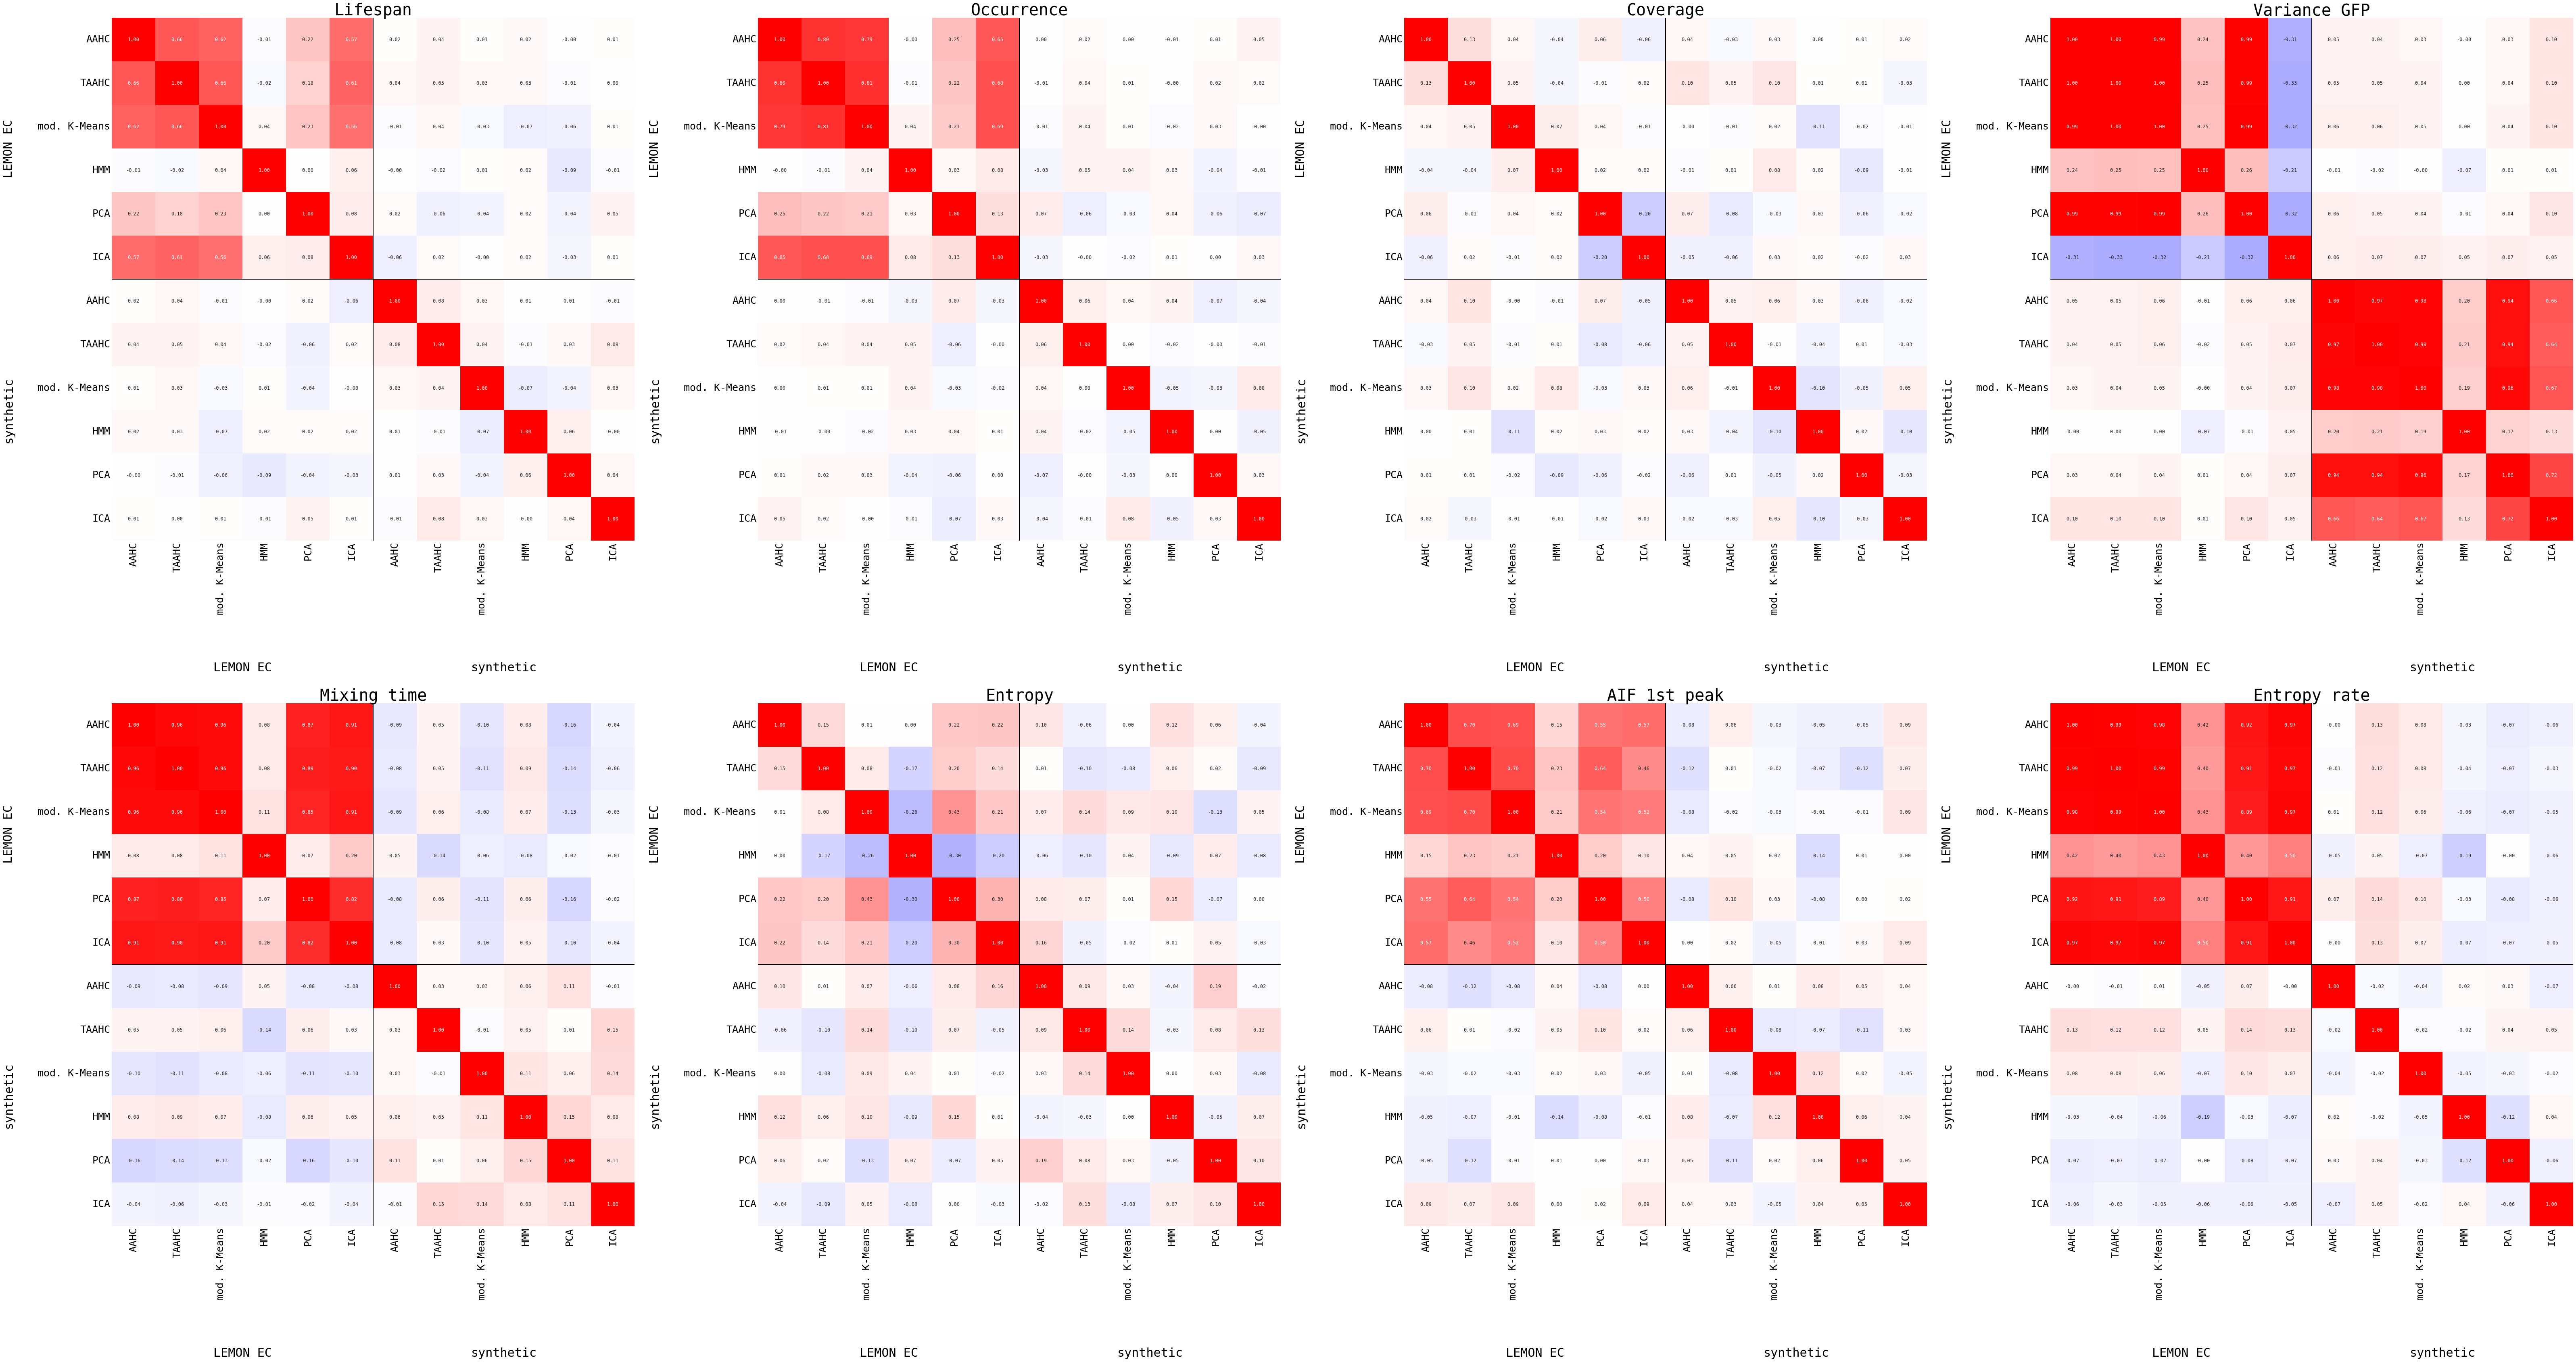

In [6]:
((g1 | g2 | g3 | g4) / (g5 | g6 | g7 | g8)).savefig(fname="real_vs_synthetic.pdf", transparent=True)